https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/GAN_for_MNIST_Tutorial.ipynb

In [7]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transform # 전처리
from torchvision.utils import save_image # 이미지 출력

### generator

In [8]:
# 노이즈분포의 dimension. norm
latent_dim = 100


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        # 선형 -> 배치정규화 -> activation leakyrelu
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28), # data 생성. 1에서 28*28로
            nn.Tanh()
        )

    def forward(self, z):# 노이즈벡터 z
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28) # reshape
        return img

### discriminator

In [10]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential( # 28*28에서 1로
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),#확률값
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1) # img 평탄화
        output = self.model(flattened)# 모델학습

        return output

### MNIST데이터셋

In [14]:
transforms_train = transforms.Compose([
    transforms.Resize(28), # 28*28
    transforms.ToTensor(), # to tensor
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4) # 배치 128

### 학습

In [12]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator() # 객체 생성
discriminator = Discriminator()

generator.cuda() # gpu
discriminator.cuda()

# 손실 함수(loss function)
# minGmaxDV(D,G)=Ex∼pdata(x)[logD(x)]+Ez∼pz(z)[log(1−D(G(z))]
# −1/n∑(yilog(pi)+(1−yi)log(1−pi))
#Binary Cross Entropy
adversarial_loss = nn.BCELoss() 
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

C:\Users\201910810\Anaconda3\lib\site-packages\torch\cuda\__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3060 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3060 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [15]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.504237] [G loss: 0.586473] [Elapsed time: 80.42s]
[Epoch 1/200] [D loss: 0.478289] [G loss: 1.539897] [Elapsed time: 84.37s]
[Epoch 2/200] [D loss: 0.519869] [G loss: 2.322962] [Elapsed time: 88.35s]
[Epoch 3/200] [D loss: 0.291653] [G loss: 1.751317] [Elapsed time: 92.34s]
[Epoch 4/200] [D loss: 0.499765] [G loss: 2.972520] [Elapsed time: 96.51s]
[Epoch 5/200] [D loss: 0.404335] [G loss: 3.156396] [Elapsed time: 100.60s]
[Epoch 6/200] [D loss: 0.264175] [G loss: 2.582276] [Elapsed time: 104.51s]
[Epoch 7/200] [D loss: 0.509419] [G loss: 0.584401] [Elapsed time: 108.64s]
[Epoch 8/200] [D loss: 0.385757] [G loss: 0.972160] [Elapsed time: 112.86s]
[Epoch 9/200] [D loss: 0.257142] [G loss: 1.556078] [Elapsed time: 117.20s]
[Epoch 10/200] [D loss: 0.326222] [G loss: 1.458638] [Elapsed time: 121.23s]
[Epoch 11/200] [D loss: 0.249318] [G loss: 1.701730] [Elapsed time: 125.14s]
[Epoch 12/200] [D loss: 0.232217] [G loss: 1.693194] [Elapsed time: 129.12s]
[Epoch 13/200]

[Epoch 107/200] [D loss: 0.236830] [G loss: 2.825078] [Elapsed time: 504.30s]
[Epoch 108/200] [D loss: 0.189746] [G loss: 2.422426] [Elapsed time: 508.19s]
[Epoch 109/200] [D loss: 0.369671] [G loss: 2.918492] [Elapsed time: 512.11s]
[Epoch 110/200] [D loss: 0.208822] [G loss: 2.242269] [Elapsed time: 516.00s]
[Epoch 111/200] [D loss: 0.236206] [G loss: 4.544458] [Elapsed time: 519.86s]
[Epoch 112/200] [D loss: 0.251843] [G loss: 1.540443] [Elapsed time: 523.73s]
[Epoch 113/200] [D loss: 0.230409] [G loss: 1.890902] [Elapsed time: 527.64s]
[Epoch 114/200] [D loss: 0.267500] [G loss: 3.570394] [Elapsed time: 531.54s]
[Epoch 115/200] [D loss: 0.288242] [G loss: 3.687916] [Elapsed time: 535.46s]
[Epoch 116/200] [D loss: 0.267477] [G loss: 2.705262] [Elapsed time: 539.46s]
[Epoch 117/200] [D loss: 0.322256] [G loss: 1.706963] [Elapsed time: 543.35s]
[Epoch 118/200] [D loss: 0.228646] [G loss: 2.147639] [Elapsed time: 547.26s]
[Epoch 119/200] [D loss: 0.228468] [G loss: 2.780736] [Elapsed t

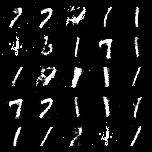

In [16]:
from IPython.display import Image

Image('92000.png')